# DTSA-5511: Week 3: CNN Cancer Detection Kaggle Mini-Project
Author: Alan Klein

Create Date: 2025-07-12

github link: https://github.com/Saganoky/DTSA-5511-CNN-Cancer-Detection

## Introduction

Having radiologists look at images to determine if someone has cancer is a time consuming and expensive task.  If computers can be trained to detect cancerous cells it will save patients time and money as well as improve cancer survival.  The following notebook uses supervised learning and convoluted neural networks to classify if images contain a tumor or not.


## Setup
The code below imports all the required packages.  This repo uses UV for package management, see https://docs.astral.sh/uv/ for more information.  If you are not familiar with UV I highly recommend you check it out. It fast and easy to use. Additionally, it is being used more and more in industry.

Ended up using the nightly update version of pytorch to support CUDA 12.9 installed using the following command

```uv pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu129```

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchsummary import summary

import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

import os

from sklearn.model_selection import train_test_split





In [2]:
# Testing PyTorch installation
x = torch.rand(5, 3)
print(x)
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"device name: {torch.cuda.get_device_name(0)}")


tensor([[0.5008, 0.1336, 0.1072],
        [0.6273, 0.3719, 0.6621],
        [0.0529, 0.2967, 0.1839],
        [0.6428, 0.4658, 0.5098],
        [0.4742, 0.9462, 0.3370]])
CUDA is available: True
device name: NVIDIA GeForce RTX 4070 SUPER


In [3]:
# This sets up the Kaggle API.  You need to have a Kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
api = KaggleApi()
api.authenticate()

In [4]:
# Run these two commands to download and unzip the data sets into the data folder.  Note that the data folder and zip file 
# are gitignored.  And the below code is commented out so that it doesn't run every time you run the notebook.

# !kaggle competitions download -c histopathologic-cancer-detection
# !unzip histopathologic-cancer-detection -d data/

## Exploratory Data Analysis (EDA)

Training Labels first 5 rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Sample Submission first 5 rows:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


Training labels shape: (220025, 2)
Sample submission shape: (57458, 2)
Unique labels in training labels: [0 1]


Label distribution in training labels:
label
0    130908
1     89117
Name: count, dtype: int64


Image size: (96, 96)
Image mode: RGB
Number of duplicate entries in training labels: 0


Randomly selected files

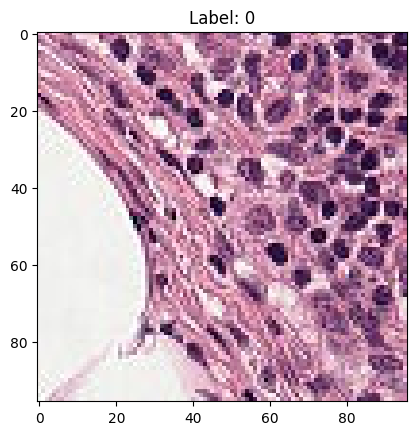

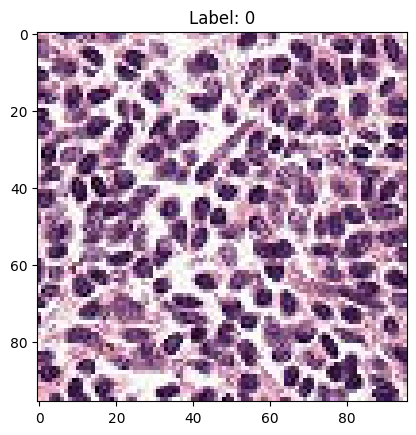

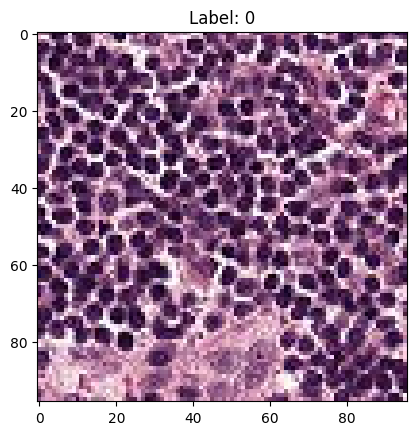

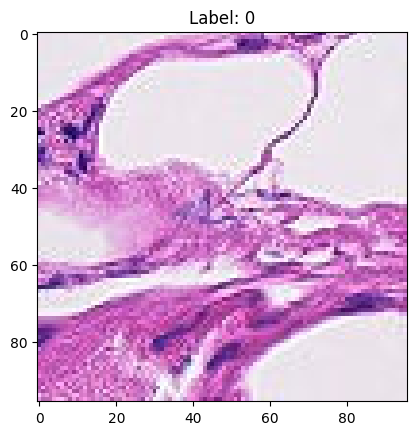

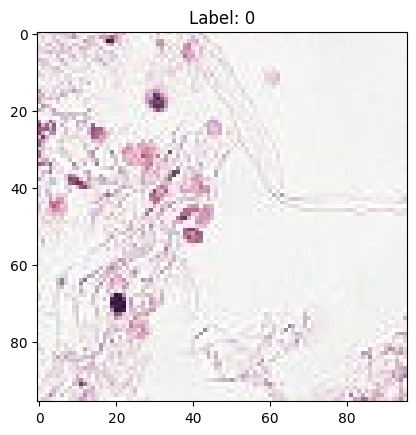

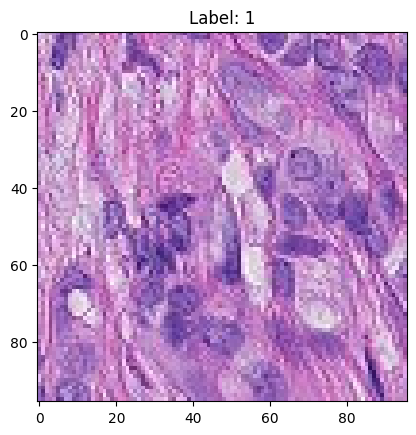

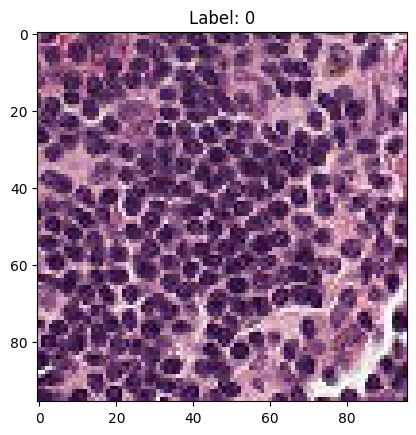

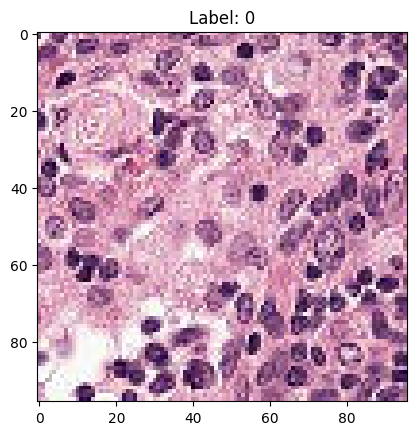

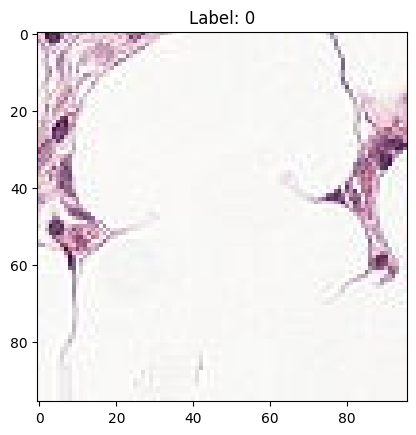

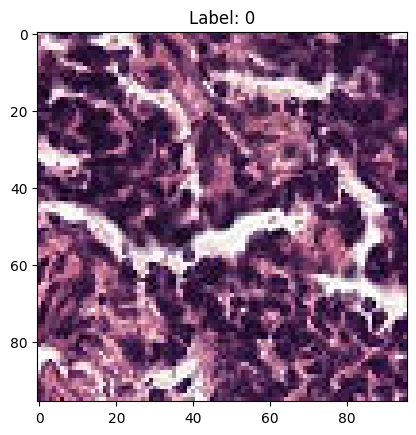

In [5]:
# Read in the data_labels as dataframe
training_labels = pd.read_csv('data/train_labels.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# Print the first few rows of the training labels dataframe
print("Training Labels first 5 rows:")
print(training_labels.head())
print("\n")

# Print the first few rows of the sample submission dataframe
print("Sample Submission first 5 rows:")
print(sample_submission.head())
print("\n")

# Print the shape of the training labels dataframe
print(f"Training labels shape: {training_labels.shape}")

# Print the shape of the sample submission dataframe
print(f"Sample submission shape: {sample_submission.shape}")

# Look at the unique values in the 'label' column of the training labels dataframe
print(f"Unique labels in training labels: {training_labels['label'].unique()}")
print("\n")

# Look at the distribution of labels in the training labels dataframe
label_counts = training_labels['label'].value_counts()
print("Label distribution in training labels:")
print(label_counts)
print("\n")

# Print the shape of the image
img = Image.open(r"C:\Users\ajkle\Development\DTSA-5511-CNN-Cancer-Detection\data\train\0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif")
print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")

# Check for duplication
number_of_duplicates = len(training_labels[training_labels.duplicated(keep=False)])
print(f"Number of duplicate entries in training labels: {number_of_duplicates}")
print("\n")

# Randomly select 5 files and visualize them
random_files = training_labels.sample(n=10, random_state=1337)

# Print the selected files
print("Randomly selected files:")
print(random_files)

for i in range(len(random_files)):
    file = random_files.iloc[i]
    image_path = f"data/train/{file['id']}.tif"
    label = str(file['label'])
    image = Image.open(image_path)
    plt.imshow(image )
    plt.title('Label: ' + label)
    plt.show()
    


### EDA Results

There are 4 things that came in the dataset.  A sample_submission.csv, a train_labels.csv, and a number of test and train tif images.

The sample_submission and train_labels are in the same format consisting of a image file name and a label.  The labels are either 0 representing no tumor
or 1 representing a tumor.  About 2/5 of the labels are 1 and 3/5 the labels are 0. This is a decent split of positive and negative results.

There are 220025 images in the train set and 57458 in the test set.  These images are 96 by 96. And there are no duplicate entries.

Some randomly selected images can be seen above.

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}.tif")
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [7]:
# split the dataset into training and validation sets
train_df, validation_df = train_test_split(training_labels, test_size=0.2, random_state=1337)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")

Training set size: 176020
Validation set size: 44005


In [8]:
# transform the images to be 1/2 size to speed up training. 
# This may not be optimal but I dont have the fastest GPU

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((46,46))])

train_set = CustomImageDataset(train_df, 'data/train', transform)

# Test the training set
print("Training set sample:")
print(train_set[10])
image,label = train_set[10]
print(f"label: {label}")
print(image.shape,torch.min(image),torch.max(image))

# Create the validation set                                       
validation_set = CustomImageDataset(validation_df, 'data/train', transform)

# Test the validation set
print("Validation set sample:")
print(validation_set[10])
image,label = validation_set[10]
print(image.shape,torch.min(image),torch.max(image))

# Create the dataloaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32,
                                            shuffle=False)

Training set sample:
(tensor([[[0.6056, 0.7550, 0.7665,  ..., 0.3675, 0.5285, 0.4358],
         [0.6154, 0.7224, 0.7764,  ..., 0.4689, 0.5366, 0.4876],
         [0.5293, 0.6583, 0.8132,  ..., 0.4443, 0.4066, 0.4586],
         ...,
         [0.8442, 0.7940, 0.4999,  ..., 0.9102, 0.9276, 0.9207],
         [0.9388, 0.8317, 0.6278,  ..., 0.9300, 0.9147, 0.9269],
         [0.8899, 0.7365, 0.4938,  ..., 0.9209, 0.9147, 0.9397]],

        [[0.3895, 0.5054, 0.5137,  ..., 0.1673, 0.3095, 0.2395],
         [0.3903, 0.4847, 0.5506,  ..., 0.2604, 0.3040, 0.2694],
         [0.2894, 0.4272, 0.6134,  ..., 0.2626, 0.1892, 0.2419],
         ...,
         [0.6592, 0.6031, 0.2968,  ..., 0.8612, 0.9187, 0.9173],
         [0.7853, 0.6570, 0.4196,  ..., 0.9181, 0.9212, 0.9194],
         [0.7590, 0.5661, 0.2919,  ..., 0.9145, 0.9131, 0.9164]],

        [[0.5094, 0.6360, 0.6341,  ..., 0.3143, 0.4658, 0.4024],
         [0.5306, 0.6083, 0.6459,  ..., 0.4123, 0.4627, 0.4271],
         [0.4424, 0.5437, 0.6867,  .

## Architecture

I decided to build a pretty standard CNN based on the recommendations from the lecture.  

I used ADAM for optimization with a learning rate or 0.01.

For loss I used cross entropy which is pretty standard for classification tasks.

As you can see above I used a pretty standard Conv+Conv+Maxpool x2 with 3 linear layers at the end.  Relu was used for the activation functions with a softmax for the classification step at the end.

For regularization I used 4 rounds of batch normalization, one before each max pool and one between linear layers of the neural net.

I stuck with 3x3 filters, 8 per convolution, for the neural nets I went with 100 and 32 for the number of nodes.  I ran the code for 10 epochs with a batch size of 32.




## Model 1

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.conv4 = nn.Conv2d(8, 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2, 2)  # Adjusted pooling to match the new architecture
        self.fc1 = nn.Linear(512, 100)
        self.bn3 = nn.BatchNorm1d(100)  # Added batch normalization after the first fully connected layer 
        self.fc2 = nn.Linear(100, 32) 
        self.bn4 = nn.BatchNorm1d(32)  # Added batch normalization after the second fully connected layer
        self.fc3 = nn.Linear(32, 2)  # Added a third fully connected layer for more complexity


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cnn_model = Net().to(device)


Using device: cuda


In [55]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2            [-1, 8, 42, 42]             584
       BatchNorm2d-3            [-1, 8, 42, 42]              16
         MaxPool2d-4            [-1, 8, 21, 21]               0
            Conv2d-5            [-1, 8, 19, 19]             584
            Conv2d-6            [-1, 8, 17, 17]             584
       BatchNorm2d-7            [-1, 8, 17, 17]              16
         MaxPool2d-8              [-1, 8, 8, 8]               0
            Linear-9                  [-1, 100]          51,300
      BatchNorm1d-10                  [-1, 100]             200
           Linear-11                   [-1, 32]           3,232
      BatchNorm1d-12                   [-1, 32]              64
           Linear-13                    [-1, 2]              66
Total params: 56,870
Trainable params: 

In [58]:
# Set the loss function to Binary Cross Entropy Loss for binary classification
criterion = nn.CrossEntropyLoss().cuda() 

# Set the optimizer to Adam with a learning rate of 0.01
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)


In [59]:
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')



[1,  1000] loss: 0.499
[1,  2000] loss: 0.446
[1,  3000] loss: 0.430
[1,  4000] loss: 0.415
[1,  5000] loss: 0.411
[2,  1000] loss: 0.404
[2,  2000] loss: 0.400
[2,  3000] loss: 0.396
[2,  4000] loss: 0.416
[2,  5000] loss: 0.396
[3,  1000] loss: 0.389
[3,  2000] loss: 0.378
[3,  3000] loss: 0.385
[3,  4000] loss: 0.377
[3,  5000] loss: 0.376
[4,  1000] loss: 0.369
[4,  2000] loss: 0.370
[4,  3000] loss: 0.379
[4,  4000] loss: 0.373
[4,  5000] loss: 0.374
[5,  1000] loss: 0.365
[5,  2000] loss: 0.369
[5,  3000] loss: 0.374
[5,  4000] loss: 0.360
[5,  5000] loss: 0.362
[6,  1000] loss: 0.362
[6,  2000] loss: 0.352
[6,  3000] loss: 0.357
[6,  4000] loss: 0.359
[6,  5000] loss: 0.357
[7,  1000] loss: 0.349
[7,  2000] loss: 0.353
[7,  3000] loss: 0.354
[7,  4000] loss: 0.356
[7,  5000] loss: 0.365
[8,  1000] loss: 0.350
[8,  2000] loss: 0.345
[8,  3000] loss: 0.353
[8,  4000] loss: 0.350
[8,  5000] loss: 0.345
[9,  1000] loss: 0.341
[9,  2000] loss: 0.343
[9,  3000] loss: 0.347
[9,  4000] 

In [60]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = cnn_model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 84 %


In [61]:
# Create the test set and loader                                    
test_set = CustomImageDataset(sample_submission, 'data/test', transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)

# Make predictions on the test set
cnn_model.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Create a submission file
submission = sample_submission.copy()
submission['label'] = predictions
submission.to_csv('data/cnn_submission_1.csv', index=False)


In [ ]:
# Use this to submit the file to Kaggle.
# !kaggle competitions submit -c histopathologic-cancer-detection -f data\cnn_submission_1.csv -m "first cnn model"

Successfully submitted to Histopathologic Cancer Detection



  0%|          | 0.00/2.41M [00:00<?, ?B/s]
 10%|█         | 256k/2.41M [00:00<00:00, 2.36MB/s]
100%|██████████| 2.41M/2.41M [00:00<00:00, 4.84MB/s]


## Results/Analysis Model 1

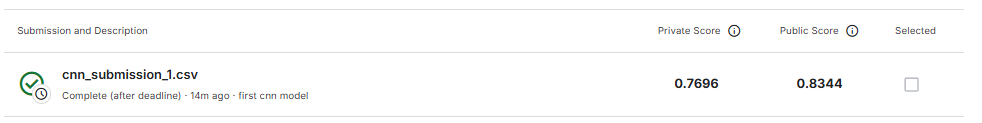

For the first model I achieved an accuracy on the validation set of 84% and a public score on Kaggle of .8344.  This is pretty good. However there are few things I would like to try in the next model.  First, it seems that the model never really converged, I already have a pretty high learning rate, so I'm going to add another convolution layer, to reduce the parameters in the neural net and increase the number of epocs.  Also I read there is value in increasing the number of filters after each conv layer so I will do that as well.


In [76]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(6, 8, 3)
        self.conv4 = nn.Conv2d(8, 10, 3)
        self.bn2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.conv5 = nn.Conv2d(10, 12, 3)
        self.conv6 = nn.Conv2d(12, 14, 3)
        self.bn3 = nn.BatchNorm2d(14)
        self.pool3 = nn.MaxPool2d(2, 2) 

        self.fc1 = nn.Linear(56, 32)
        self.bn4 = nn.BatchNorm1d(32)  
        self.fc2 = nn.Linear(32, 16) 
        self.bn5 = nn.BatchNorm1d(16)  
        self.fc3 = nn.Linear(16, 2)  


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    

cnn_model_2 = Net_2().to(device)


In [77]:
from torchsummary import summary
summary(cnn_model_2, input_size=(3, 46, 46), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 44, 44]             112
            Conv2d-2            [-1, 6, 42, 42]             222
       BatchNorm2d-3            [-1, 6, 42, 42]              12
         MaxPool2d-4            [-1, 6, 21, 21]               0
            Conv2d-5            [-1, 8, 19, 19]             440
            Conv2d-6           [-1, 10, 17, 17]             730
       BatchNorm2d-7           [-1, 10, 17, 17]              20
         MaxPool2d-8             [-1, 10, 8, 8]               0
            Conv2d-9             [-1, 12, 6, 6]           1,092
           Conv2d-10             [-1, 14, 4, 4]           1,526
      BatchNorm2d-11             [-1, 14, 4, 4]              28
        MaxPool2d-12             [-1, 14, 2, 2]               0
           Linear-13                   [-1, 32]           1,824
      BatchNorm1d-14                   

In [78]:
# Set the loss function to Binary Cross Entropy Loss for binary classification
criterion = nn.CrossEntropyLoss().cuda() 

# Set the optimizer to Adam with a learning rate of 0.01
optimizer = optim.Adam(cnn_model_2.parameters(), lr=0.01)

In [80]:
epochs = []
epoch_loss = []

for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = cnn_model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

    epochs.append(epoch + 1)  
    epoch_loss.append(running_loss / 1000)


print('Finished Training')

[1,  1000] loss: 0.676
[1,  2000] loss: 0.676
[1,  3000] loss: 0.677
[1,  4000] loss: 0.675
[1,  5000] loss: 0.676
[2,  1000] loss: 0.676
[2,  2000] loss: 0.677
[2,  3000] loss: 0.676
[2,  4000] loss: 0.676
[2,  5000] loss: 0.677
[3,  1000] loss: 0.677
[3,  2000] loss: 0.676
[3,  3000] loss: 0.677
[3,  4000] loss: 0.677
[3,  5000] loss: 0.674
[4,  1000] loss: 0.676
[4,  2000] loss: 0.676
[4,  3000] loss: 0.674
[4,  4000] loss: 0.676
[4,  5000] loss: 0.677
[5,  1000] loss: 0.676
[5,  2000] loss: 0.676
[5,  3000] loss: 0.675
[5,  4000] loss: 0.677
[5,  5000] loss: 0.676
[6,  1000] loss: 0.676
[6,  2000] loss: 0.676
[6,  3000] loss: 0.676
[6,  4000] loss: 0.675
[6,  5000] loss: 0.676
[7,  1000] loss: 0.676
[7,  2000] loss: 0.676
[7,  3000] loss: 0.676
[7,  4000] loss: 0.677
[7,  5000] loss: 0.676
[8,  1000] loss: 0.677
[8,  2000] loss: 0.674
[8,  3000] loss: 0.675
[8,  4000] loss: 0.676
[8,  5000] loss: 0.676
[9,  1000] loss: 0.676
[9,  2000] loss: 0.677
[9,  3000] loss: 0.675
[9,  4000] 

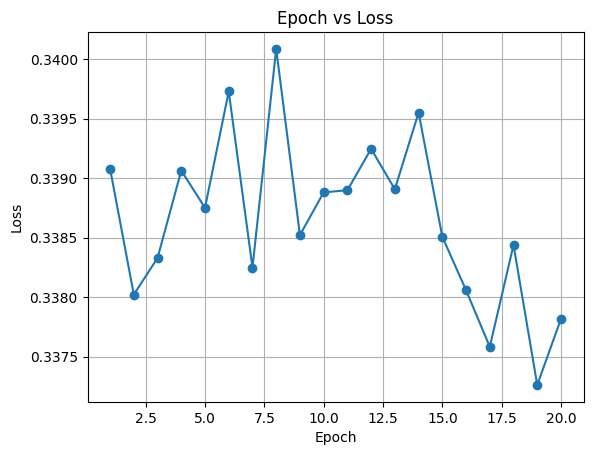

In [82]:
# Plot the loss over epochs
plt.plot(epochs, epoch_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.grid(True)
plt.show()

In [83]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = cnn_model_2(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 59 %


In [89]:
# Create the test set and loader                                    
test_set = CustomImageDataset(sample_submission, 'data/test', transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)

# Make predictions on the test set
cnn_model_2.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = cnn_model_2(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Create a submission file
submission = sample_submission.copy()
submission['label'] = predictions
submission.to_csv('data/cnn_submission_2.csv', index=False)

In [90]:
# Use this to submit the file to Kaggle.
!kaggle competitions submit -c histopathologic-cancer-detection -f data\cnn_submission_2.csv -m "second cnn model"

Successfully submitted to Histopathologic Cancer Detection



  0%|          | 0.00/2.41M [00:00<?, ?B/s]
 19%|█▉        | 480k/2.41M [00:00<00:00, 4.89MB/s]
100%|██████████| 2.41M/2.41M [00:00<00:00, 5.23MB/s]


## Result/Analysis Model 2

My ideas for changes for model 2 failed.  As you can see in the above chart as well as the accuracy in the validation set of 59%.  The model didn't work  at all.  My guess is either the learning rate is too high for the architecture or it didn't have enough features for the neural net to find any meaningful patterns.  See the Kaggle score below.

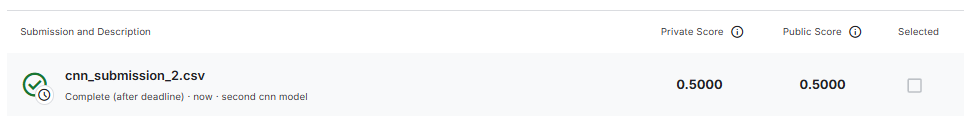


## Conclusion
CNN models are well suited to image classification tasks.  My first model showed this, however my second model failed.  This shows that there is future hyper parameter tuning that could be done to improve the model.  The next things I would investigate would be to increase the number of epochs in my first model and investigate some sort of adaptive learning rate.  Also, exploring the tradeoff between batch size and run time would be of interest as one of the challenges of neural networks is the long training time.

## References

https://www.geeksforgeeks.org/deep-learning/building-a-convolutional-neural-network-using-pytorch/

https://docs.pytorch.org/tutorials/beginner/basics/intro.html

https://github.com/pytorch/examples/blob/main/mnist/main.py